In [1]:
import torch
import torch.nn as nn
import pandas as pd
from HGP.models import LightModel
import pickle

In [2]:
import networkx as nx

In [3]:
from utils.imports import *
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.profilers import SimpleProfiler

In [6]:
# %%
args_dict = take_hp("log/hgp/hpt-75002.yml")

pl.seed_everything(args_dict["random_seed"], workers=True)


Global seed set to 42


42

In [7]:
# %%
# Load the dataset
dataset = TUDataset(
    Path.cwd().joinpath("datasets"),
    name=args_dict["dataset"],
    use_node_attr=True,
)
args_dict["num_classes"] = dataset.num_classes
args_dict["num_features"] = dataset.num_features

Extracting /home/bjoern/AML22-project/datasets/ENZYMES/ENZYMES.zip
Processing...
Done!


In [8]:
# %%
# filename, filepath = save_config(args_dict)

In [12]:
# %%
# split_train = int(dataset.len() * args_dict["split_ratio"])
# split_val = int((dataset.len() - split_train) * args_dict["test_ratio"])
# split_val = int(dataset.len() * args_dict["split_ratio"])
# split_test = split_val + int(
#     (dataset.len() - split_val) * args_dict["test_ratio"]
# )  # - split_val - split_train

# print(
#     f"Hole: {dataset.len()}, Train: {split_val}, Val: {dataset.len() - split_test}, Test: {dataset.len() - split_test}"
# )

In [13]:
# train_data = dataset[0:split_val]
# eval_data = dataset[split_val:split_test]
# test_data = dataset[split_test:]

In [14]:
split_train = int(dataset.len() * args_dict["split_ratio"])
split_val = int((dataset.len() - split_train) * args_dict["test_ratio"])
split_test = dataset.len() - split_val - split_train

print(
    f"Hole: {dataset.len()}, Train: {split_train}, Val: {split_val}, Test: {split_test}"
)
# %%
train_data, eval_data, test_data = random_split(
    dataset,
    [split_train, split_val, split_test],
    generator=torch.Generator().manual_seed(42),
)

Hole: 600, Train: 420, Val: 90, Test: 90


train_data, eval_data, test_data = random_split(
    dataset,
    [split_train, split_val, split_test],
    generator=torch.Generator().manual_seed(42),
)

In [15]:
# %%
train_loader = DataLoader(
    train_data,
    batch_size=args_dict["batch_size"],
    shuffle=False,
    num_workers=args_dict["num_workers"],
)
val_loader = DataLoader(
    eval_data,
    batch_size=args_dict["batch_size"],
    shuffle=False,
    num_workers=args_dict["num_workers"],
)
test_loader = DataLoader(
    test_data,
    batch_size= 1 ,# dataset.len() - split_test,
    shuffle=False,
    num_workers=args_dict["num_workers"],
)

In [34]:
# p_list = []

# for batch in test_loader:

#     data = batch.to(args_dict["device"])
#     e, X, y, b, p = data
#     p_list.append(b[1])

# # -
# liste = torch.cat(p_list).cpu().numpy()
# Define the model
model = LightModel(args_dict).to(args_dict["device"])
# load a saved model
weights = torch.load("model/hpt-75/hpt-75/model.pt")
# set the weights
model.load_state_dict(weights)

model.eval()

loss = nn.CrossEntropyLoss(reduction="none")
softmax = nn.Softmax(dim=1)

In [36]:
all_b = []
all_y = []
all_loss = []
all_graphs = []

for batch in test_loader:
    data = batch.to(args_dict["device"])
    out = model(data)
    
    print(softmax(out) == data.y)

    print(softmax(out), data.y)
    break

all_loss = torch.cat(all_loss).detach().cpu().numpy()

tensor([[False,  True, False, False, False, False]], device='cuda:0')
tensor([[1.2080e-30, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0991e-33]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [26]:
all_loss

array([-0.], dtype=float32)

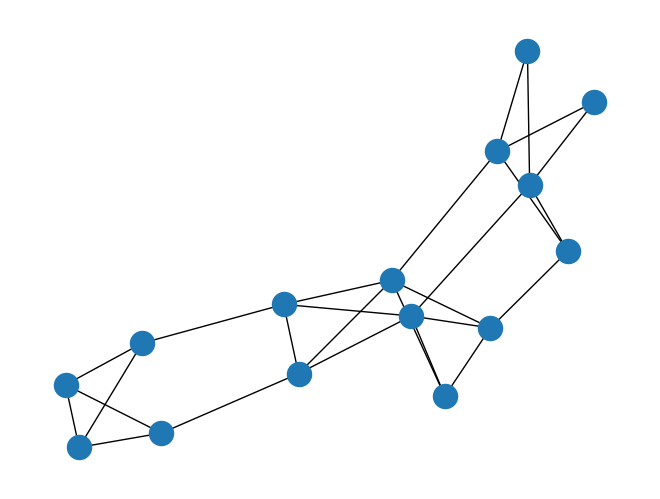

In [32]:
nx.draw(all_graphs[5])

In [19]:
g = nx.Graph(e[1].cpu().numpy().T.tolist())

In [20]:
nx.info(g)

/tmp/ipykernel_22810/3034883828.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(g)


'Graph with 10 nodes and 20 edges'

In [22]:
y

('y', tensor([1], device='cuda:0'))

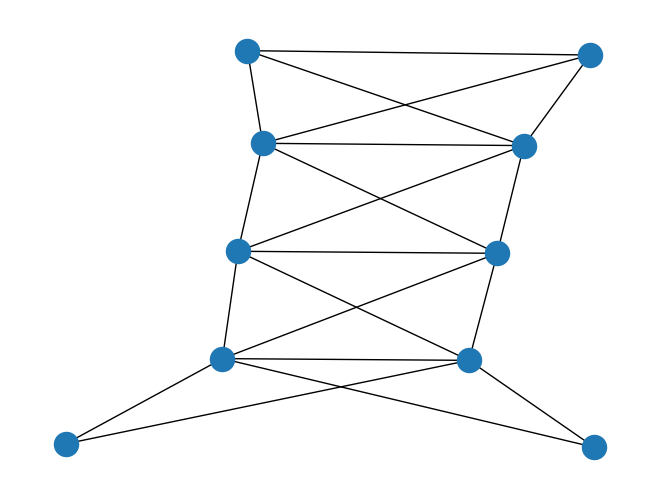

In [21]:
nx.draw(g)

In [10]:
print(np.shape(all_loss))
print(np.shape(all_b))
print(np.shape(all_y))

(90,)
(90,)
(90,)


In [15]:
#os.mkdir("df")

In [11]:
two = pd.DataFrame({"b": all_b, "y": all_y, "loss": all_loss})

In [17]:
# load dataframe from csv first column is index
df = pd.read_csv(f"df/{args_dict['dataset']}.csv", index_col=0)

In [12]:
two

,b,y,loss
0,0,1,0.004571
1,1,3,1.066132
2,2,0,1.288731
3,3,0,1.274440
4,4,4,2.752469
...,...,...,...
85,85,4,0.019770
86,86,5,2.679007
87,87,1,1.054355
88,88,3,1.120262


In [18]:
df

,b,y,loss
0,0,1,0.004571
1,1,3,1.066132
2,2,0,1.288730
3,3,0,1.274439
4,4,4,2.752469
...,...,...,...
85,85,4,0.019770
86,86,5,2.679009
87,87,1,1.054355
88,88,3,1.120262


In [15]:
from utils.to_graph import tud_to_networkx as to_nx


In [17]:
graph_db = to_nx("PROTEINS")

FileNotFoundError: [Errno 2] No such file or directory: './datasets/PROTEINS/PROTEINS/raw/PROTEINS_graph_indicator.txt'

In [ ]:
nx.draw(graph_db[0])

In [ ]:
nx.info(graph_db[0])